In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import ttest_ind, f_oneway, mannwhitneyu, stats
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Data

In [2]:
# levantamos los datos
df = pd.read_csv('podcast_dataset.csv')

df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Podcast_Name                 52500 non-null  object 
 1   Episode_Title                52500 non-null  object 
 2   Episode_Length_minutes       47254 non-null  float64
 3   Genre                        52500 non-null  object 
 4   Host_Popularity_percentage   52500 non-null  float64
 5   Publication_Day              52500 non-null  object 
 6   Publication_Time             52500 non-null  object 
 7   Guest_Popularity_percentage  47242 non-null  float64
 8   Number_of_Ads                52500 non-null  int64  
 9   Episode_Sentiment            52500 non-null  object 
 10  Listening_Time_minutes       47105 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 4.4+ MB


,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN


In [3]:
df.isnull().sum()

Podcast_Name                      0
Episode_Title                     0
Episode_Length_minutes         5246
Genre                             0
Host_Popularity_percentage        0
Publication_Day                   0
Publication_Time                  0
Guest_Popularity_percentage    5258
Number_of_Ads                     0
Episode_Sentiment                 0
Listening_Time_minutes         5395
dtype: int64

In [4]:
df.drop(columns=['Podcast_Name', 'Episode_Title'], inplace=True)

df = pd.get_dummies(df, columns=['Genre', 'Episode_Sentiment', 'Publication_Day', 'Publication_Time'], drop_first=True)

df = df.astype('int64', errors='ignore')


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Episode_Length_minutes       47254 non-null  float64
 1   Host_Popularity_percentage   52500 non-null  float64
 2   Guest_Popularity_percentage  47242 non-null  float64
 3   Number_of_Ads                52500 non-null  int64  
 4   Listening_Time_minutes       47105 non-null  float64
 5   Genre_Comedy                 52500 non-null  int64  
 6   Genre_Education              52500 non-null  int64  
 7   Genre_Health                 52500 non-null  int64  
 8   Genre_Lifestyle              52500 non-null  int64  
 9   Genre_Music                  52500 non-null  int64  
 10  Genre_News                   52500 non-null  int64  
 11  Genre_Sports                 52500 non-null  int64  
 12  Genre_Technology             52500 non-null  int64  
 13  Genre_True Crime

Metricas no muy buenas. Pruebo hacer un analisis con componentes principales. Primero estandarizo.

In [6]:
# Eliminar filas con valores nulos
df.dropna(subset=['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Listening_Time_minutes'], inplace=True)

# Dividir datos en features (X) y target (y)
X = df.drop(columns=['Listening_Time_minutes'])
y = df['Listening_Time_minutes']

# Seleccionar las columnas numéricas para estandarizar
columns_to_standardize = ['Episode_Length_minutes', 
                          'Host_Popularity_percentage', 
                          'Guest_Popularity_percentage',
                          'Number_of_Ads']

# Crear un objeto StandardScaler
scaler = StandardScaler()

# Aplicar la estandarización solo a las columnas numéricas
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

# Verificar los resultados
df.head()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Genre_Comedy,Genre_Education,Genre_Health,Genre_Lifestyle,Genre_Music,...,Episode_Sentiment_Positive,Publication_Day_Monday,Publication_Day_Saturday,Publication_Day_Sunday,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night
0,1.093722,-1.674466,0.697512,1.340606,55.158695,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
1,-1.309113,-0.558970,0.868034,-0.450075,7.686559,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1.628957,1.564015,0.273107,1.340606,110.064645,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,-1.383167,-1.486102,-0.894609,-1.345416,12.000380,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
6,0.025662,-0.055658,1.111885,-1.345416,57.827346,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0


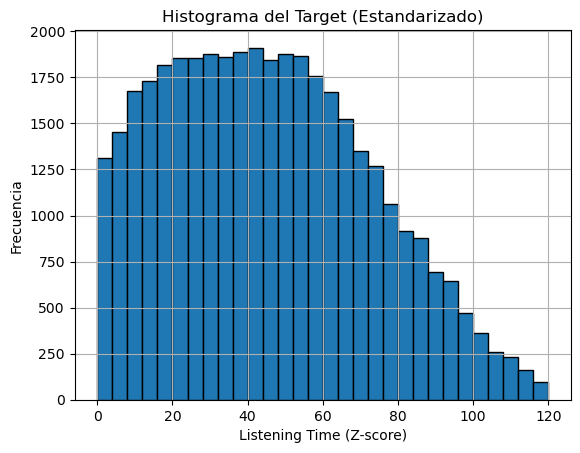

In [7]:
plt.hist(df['Listening_Time_minutes'], bins=30, edgecolor='black')
plt.title('Histograma del Target (Estandarizado)')
plt.xlabel('Listening Time (Z-score)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [8]:
# Seleccionamos las columnas numéricas y las variables de One-Hot Encoding
numerical_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 
                  'Guest_Popularity_percentage', 'Number_of_Ads']

# Variables de One-Hot Encoding (que ya se aplicaron)
categorical_cols = ['Genre_Comedy', 'Genre_Education', 'Genre_Health', 'Genre_Lifestyle', 
                    'Genre_Music', 'Genre_News', 'Genre_Sports', 'Genre_Technology', 'Genre_True Crime', 
                    'Episode_Sentiment_Neutral', 'Episode_Sentiment_Positive', 
                    'Publication_Day_Monday', 'Publication_Day_Saturday', 'Publication_Day_Sunday', 
                    'Publication_Day_Thursday', 'Publication_Day_Wednesday', 
                    'Publication_Time_Morning', 'Publication_Time_Night']

# Juntar las columnas numéricas y de One-Hot Encoding
X = df[numerical_cols + categorical_cols]

# Estandarizar las variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Seleccionar cuántos componentes usar (ej. retener el 90% de la varianza)
cumulative_variance = pca.explained_variance_ratio_.cumsum()
components_to_keep = (cumulative_variance <= 0.90).sum() + 1  # 90% de varianza explicada
X_pca_reduced = X_pca[:, :components_to_keep]

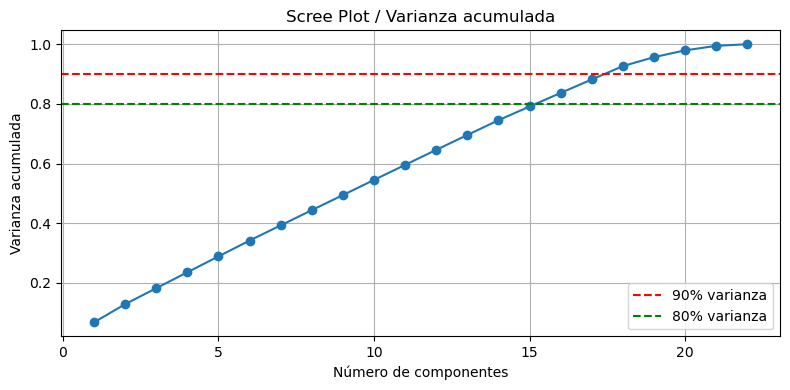

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% varianza')
plt.axhline(y=0.80, color='g', linestyle='--', label='80% varianza')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Scree Plot / Varianza acumulada')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Definimos grids de hiperparámetros
param_grids = {
    "Ridge": {
        "alpha": [0.01, 0.1, 1, 10, 100]
    },
    "Lasso": {
        "alpha": [0.001, 0.01, 0.1, 1, 10]
    },
    "Gradient Boosting": {
        "n_estimators": [200],
        "learning_rate": [0.1],
        "max_depth": [5]
    },
    #"SVR": {
    #    "C": [0.1, 1, 10],
    #    "gamma": ['scale', 'auto'],
    #    "kernel": ['rbf', 'linear']
    #},
    "Random Forest": {
        "n_estimators": [100],  # Número de árboles
        "max_depth": [10],  # Profundidad de los árboles
        "min_samples_split": [2, 5],  # Mínimo de muestras para dividir un nodo
        "min_samples_leaf": [4],  # Mínimo de muestras en una hoja
        "random_state": [42]  # Random state para reproducibilidad
    }
}

# Modelos base
model_objs = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Gradient Boosting": GradientBoostingRegressor(),
    #"SVR": SVR(),
    "Random Forest": RandomForestRegressor()
}

print("Set Original")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Loop por cada modelo con hiperparámetros
for name in param_grids:
    print(f"--- {name} ---")
    grid = GridSearchCV(model_objs[name], param_grids[name], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)  
    rmse = np.sqrt(mse)  
    
    print(f"Mejores params: {grid.best_params_}")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}\n")



print("Set PCA")

X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

# Loop por cada modelo con hiperparámetros
for name in param_grids:
    print(f"--- {name} ---")
    grid = GridSearchCV(model_objs[name], param_grids[name], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)  
    rmse = np.sqrt(mse)  

    print(f"Mejores params: {grid.best_params_}")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}\n")
    


Set Original
--- Ridge ---
Mejores params: {'alpha': 100}
MAE: 8.8979, MSE: 127.6658
RMSE: 11.2989
R² Score: 0.8284

--- Lasso ---
Mejores params: {'alpha': 0.1}
MAE: 8.8950, MSE: 127.8273
RMSE: 11.3061
R² Score: 0.8282

--- Gradient Boosting ---
Mejores params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
MAE: 8.7653, MSE: 124.4197
RMSE: 11.1544
R² Score: 0.8328

--- Random Forest ---
Mejores params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}
MAE: 8.7891, MSE: 124.5660
RMSE: 11.1609
R² Score: 0.8326

Set PCA
--- Ridge ---
Mejores params: {'alpha': 100}
MAE: 8.9003, MSE: 127.7331
RMSE: 11.3019
R² Score: 0.8283

--- Lasso ---
Mejores params: {'alpha': 0.01}
MAE: 8.9009, MSE: 127.6945
RMSE: 11.3002
R² Score: 0.8284

--- Gradient Boosting ---
Mejores params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
MAE: 8.8557, MSE: 126.8527
RMSE: 11.2629
R² Score: 0.8295

--- Random Forest ---
Mejores params:

In [11]:
# Seleccionar solo las columnas numéricas relevantes
numeric_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage',
                'Guest_Popularity_percentage', 'Number_of_Ads',
                'Listening_Time_minutes']

# Calcular la matriz de correlación
correlation_matrix = df[numeric_cols].corr()

# Mostrar solo la correlación con el target
print(correlation_matrix['Listening_Time_minutes'].sort_values(ascending=False))

Listening_Time_minutes         1.000000
Episode_Length_minutes         0.902334
Host_Popularity_percentage     0.047682
Guest_Popularity_percentage    0.000535
Number_of_Ads                 -0.089788
Name: Listening_Time_minutes, dtype: float64


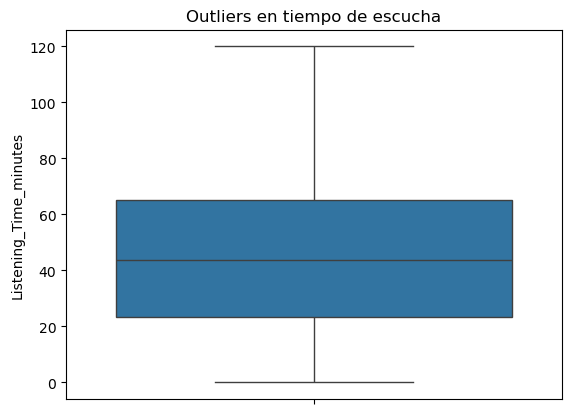

In [12]:
sns.boxplot(y=df['Listening_Time_minutes'])
plt.title("Outliers en tiempo de escucha")
plt.show()

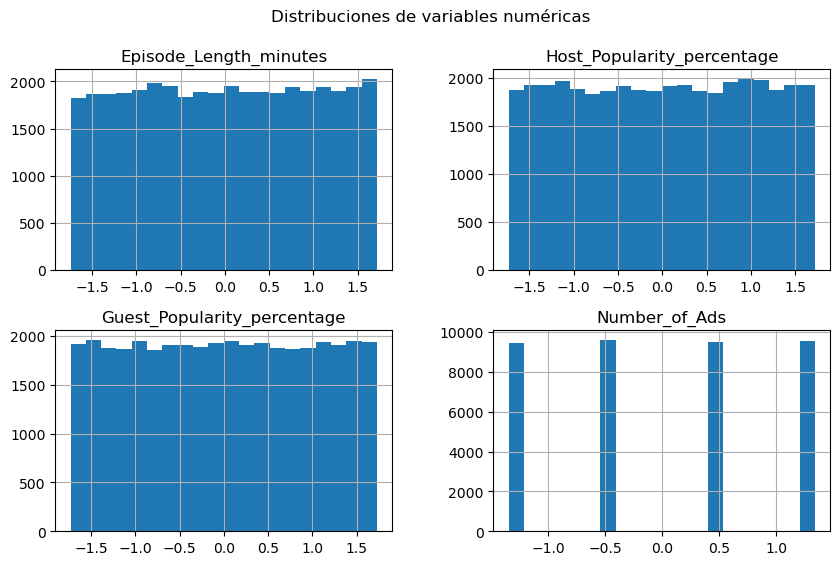

In [13]:
df[['Episode_Length_minutes', 'Host_Popularity_percentage',
    'Guest_Popularity_percentage', 'Number_of_Ads']].hist(bins=20, figsize=(10, 6))
plt.suptitle("Distribuciones de variables numéricas")
plt.show()
